# Contrastive Variational Autoencoder for the MNIST-Data-Set

Tobias Haase

I am slightly orienting myself on a paper from [Abid & Zou (2019)](https://arxiv.org/abs/1902.04601)
## Set Up
Firstly I am loading the required modules.

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio 

import os
os.chdir("/home/tchaase/Documents/Universitaet/Master-Arbeit/pytorch_mnist_VAE/")

As with the [vae](vae.ipynb) I will firstly also define the utility functions. 

In [2]:
def final_loss(bce_loss, z_mu, z_logvar, s_mu, s_logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: reconstruction loss
    :param z_mu: mean from the latent vector of encoder_z
    :param z_logvar: log variance from the latent vector of encoder_z
    :param s_mu: mean from the latent vector of encoder_s (optional)
    :param s_logvar: log variance from the latent vector of encoder_s (optional)
    """
    BCE = bce_loss
    KLD_z = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    if s_mu is not None and s_logvar is not None:
        KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
        return BCE + KLD_z + KLD_s
    else:
        return BCE + KLD_z
    
    # Use cross entropy for mri images perhaps, more appropriate than bce. 

Here the training function

In [3]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss_bg = 0.0
    running_loss_target = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, (target_data, background_data) in tqdm(enumerate(dataloader), total= total_batches):
        target_data = target_data.to(device)
        background_data = background_data.to(device)
                       
        optimizer.zero_grad()
        
        z_mean, z_log_var, s_mean, s_log_var, z_mean_bg, z_log_var_bg, reconstructed_data_target, reconstructed_data_bg = model(target_data, background_data)

        # Section for the target images
        bce_loss_target = criterion(reconstructed_data_target, target_data)
        loss_target = final_loss(bce_loss_target, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_target += loss_target.item()
        loss_target.backward()

        # Section for the background images
        bce_loss_background = criterion(reconstructed_data_bg, background_data)
        s_mean_bg, s_log_var_bg = None, None
        loss_background = final_loss(bce_loss_background, z_mean_bg, z_log_var_bg, s_mean_bg, s_log_var_bg)
        loss_background.backward()  # Using the loss, backpropagation occurs. Thus, all the tensors that will be connected to this, will be involved in this computation. 
        running_loss_bg += loss_background.item() #This here defined for every step along the way, how high is the loss. 
    
        optimizer.step()
        counter += len(target_data)
    train_loss_target = running_loss_target / counter
    train_loss_bg = running_loss_bg / counter
    return train_loss_target, train_loss_bg

Here the validation functions:

In [4]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    
    total_batches = len(dataset) // dataloader.batch_size
    with torch.no_grad():
        for i, (target_data, background_data) in tqdm(enumerate(dataloader), total=total_batches):
            background_data = background_data.to(device)
            
            # Perform the forward pass
            z_mean, z_log_var, s_mean, s_log_var, z_mean_bg, z_log_var_bg, reconstructed_data_target, reconstructed_data_bg = model(target_data, background_data)
            
            # Compute the loss
            bce_loss_target = criterion(reconstructed_data_target, target_data)
            loss_target = final_loss(bce_loss_target, z_mean, z_log_var, s_mean, s_log_var)
            running_loss += loss_target.item()
            
            counter += target_data.size(0)  # Increment the counter by the batch size (number of samples in the current batch)
            
            # save the last batch input and output of every epoch
            if i == len(dataloader) - 1:
                recon_images = reconstructed_data_target
    
    val_loss = running_loss / counter
    return val_loss, recon_images


Now, lastly I will define some parameters that I will use before I define the full model.

In [5]:
kernel_size = 4 
init_channels = 8 # initial number of filters, first layers output. 
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling
stride = 2
channels = 1  #working with grayscale. 
lr = 0.001
same = 0

In [6]:
tensor = torch.randn(64, 16, 8, 8)
h = tensor.view(64,-1)

h.shape

torch.Size([64, 1024])

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
latent_dim = 16


class EncoderZ(nn.Module):
    def __init__(self, latent_dim):
        super(EncoderZ, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=init_channels, out_channels=init_channels * 2, kernel_size=kernel_size, stride=stride, padding=1)
        self.fc1 = nn.Linear(init_channels*2* 8 * 8, 256) # t applies a linear transformation to the input data, which means it computes the dot product of the input and weight tensors, adds the bias term, and produces the output.
        self.fc_mean = nn.Linear(256, (16))
        self.fc_log_var = nn.Linear(256, (16))

    def forward(self, x, batch_size):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(batch_size,-1)
        h = F.relu(self.fc1(h))
        z_mean = self.fc_mean(h)  
        z_log_var = self.fc_log_var(h)
        return z_mean, z_log_var

class EncoderS(nn.Module):
    def __init__(self, latent_dim):
        super(EncoderS, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=init_channels, out_channels=init_channels * 2, kernel_size=kernel_size, stride=stride, padding=1)
        self.fc1 = nn.Linear(init_channels * 2*8 * 8, 256)
        self.fc_mean = nn.Linear(256, (16))
        self.fc_log_var = nn.Linear(256, (16))

    def forward(self, x, batch_size):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = h.view(batch_size,-1)
        h = F.relu(self.fc1(h))
        s_mean = self.fc_mean(h)
        s_log_var = self.fc_log_var(h)
        return s_mean, s_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear((16* 2), 256)
        self.fc2 = nn.Linear(256, 2048)  # Adjust the output size of fc2
        self.conv1 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=4, stride=2, padding=1)  # Set input channels to 1
        self.conv2 = nn.ConvTranspose2d(in_channels=init_channels*2, out_channels = image_channels, kernel_size=4, stride=2, padding= 1 )

    def forward(self, zs, batch_size):
        x = F.relu(self.fc1(zs))
        x = F.relu(self.fc2(x))
        x = x.view(batch_size, 32, 8, 8)  # Reshape to a 4-dimensional ten
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

class cVAE(nn.Module):
    def __init__(self, latent_dim):
        super(cVAE, self).__init__()
        self.encoder_z = EncoderZ(latent_dim)
        self.encoder_s = EncoderS(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.overlay_status = None 

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std
    


    def forward(self, target_image, bg_image):
        batch_size = target_image.size(0) 
        z_mean, z_log_var = self.encoder_z(target_image, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(target_image, batch_size)
        s = self.reparameterize(s_mean, s_log_var)      
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_target = self.decoder(zs, batch_size)

        z_mean_bg, z_log_var_bg = self.encoder_z(bg_image, batch_size)
        z_bg = self.reparameterize(z_mean_bg, z_log_var_bg)
        z_empty = torch.zeros_like(z_bg)
        z_bg_0 = torch.cat([z_bg, z_empty], dim =1)
        reconstructed_data_bg = self.decoder(z_bg_0, batch_size)
        
        return z_mean, z_log_var, s_mean, s_log_var, z_mean_bg, z_log_var_bg, reconstructed_data_target, reconstructed_data_bg


Right now, I can't directly access the images to superimpose them. Therefore, I will have to get the images with the following function. Additionally, I have incorporated a greyscaler into this. 

In [8]:
from PIL import Image
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_' + str(idx))
    d = unpickle(data_file)
    x = d['data']
    y = d['labels']
    mean_image = d['mean']

    x = x / np.float32(255)
    mean_image = mean_image / np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i - 1 for i in y]
    data_size = x.shape[0]

    x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2 * img_size2], x[:, 2 * img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_train = x[0:data_size, :, :, :]
    Y_train = y[0:data_size]
    X_train_flip = X_train[:, :, :, ::-1]
    Y_train_flip = Y_train
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return dict(
        X_train=X_train.astype(np.float32),
        Y_train=np.array(Y_train, dtype=np.int32),
        mean=mean_image.astype(np.float32)
    )


Let's superimpose them with each other!

Firstly here is the way I loaded the mnist pictures as it was done before [here](./vae.ipynb). The data is loaded and resized to 32x32 to fit the Image-Net Data. 
I have once again split the data into a training and validation set. 


In [9]:
# Data transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(
    root='./input', train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root='./input', train=False, download=True, transform=transform
)

Firstly I am unpickleing one batch and doing the calculations that were previously defined. 

In [10]:
batch_1 = load_databatch("./input/Imagenet32_train", 1)


Now, lets split the channels into matrices to then greyscale them. 

In [11]:
image_data = batch_1["X_train"]

# Get the number of images
num_images = len(image_data)

# Initialize an empty array to store the reshaped grayscale images
grayscale_images = np.empty((num_images, 32, 32), dtype=np.float32)

print("The shape is now: ",image_data.shape)

# Reshape the images
for i, image in enumerate(image_data):
    # Reshape the image to match the color channel dimensions (3x32x32)
    image = np.reshape(image, (3, 32, 32))

    # Split the image into separate color channels
    red_channel = image[0]
    green_channel = image[1]
    blue_channel = image[2]

    # Combine the color channels weighted by their respective coefficients to form the grayscale image - these values are taken from recommedations from ChatGPT
    grayscale_image = 0.2989 * red_channel + 0.5870 * green_channel + 0.1140 * blue_channel

    # Normalize the grayscale image to the range [0, 1]
    grayscale_image /= 255.0

    # Store the grayscale image in the array
    grayscale_images[i] = grayscale_image

# Store the reshaped grayscale images in a new entry in the dictionary
batch_1["X_train_gray"] = grayscale_images
print("The shape is now: ",grayscale_images.shape)

The shape is now:  (256232, 3, 32, 32)
The shape is now:  (256232, 32, 32)


This seemed to have worked. Now, lets move on to overlaying them. The following still needs proper testing. 

In [53]:
import random
import torch
from torchvision import datasets, transforms

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
mnist_data = datasets.MNIST(root='./input', train=True, download=True, transform=transform)

# Access the background images from the dictionary
background_images = batch_1["X_train_gray"]

# Create a list to store the overlaid images
target_images = []
overlayed_count = 0

# Create a list to store the background images (and load them)
bg_images = []
not_overlayed_count = 0

# Shuffle the indices of the MNIST dataset
mnist_indices = list(range(len(mnist_data)))
random.shuffle(mnist_indices)

# Assuming background_images and mnist_data are lists
for i in range(len(background_images)):
    background_image = background_images[i]
    random_overlay = random.random() < 0.5  # Randomly choose whether to overlay MNIST image or not

    if random_overlay and overlayed_count < len(mnist_data):  # Overlay MNIST image if there are MNIST images left
        random_index = mnist_indices[overlayed_count]  # Use the next randomly shuffled index
        mnist_image, _ = mnist_data[random_index]

        # Invert the MNIST image
        mnist_image = 1.0 - mnist_image

        # Convert background image to tensor and move it to the CUDA device
        background_tensor = torch.tensor(background_image).unsqueeze(0).to(device)

        # Resize the background image to match the MNIST image dimensions
        resized_background_tensor = transforms.Resize((32, 32))(background_tensor)

        # Resize MNIST image to match the background image dimensions
        mnist_resized = transforms.Resize((32, 32))(mnist_image)

        overlaid_tensor = resized_background_tensor + mnist_resized.to(device)

        target_images.append(overlaid_tensor)  # Store information that the image was overlaid
        overlayed_count += 1

    else:
        background_tensor = torch.tensor(background_image).unsqueeze(0).to(device)
        resized_background_tensor = transforms.Resize((32, 32))(background_tensor)

        bg_images.append(resized_background_tensor)  # Store information that the image was not overlaid
        not_overlayed_count += 1

# Print the counts of overlaid and non-overlaid images
print(f"Overlayed Images: {overlayed_count}")
print(f"Not Overlayed Images: {not_overlayed_count}")


Overlayed Images: 60000
Not Overlayed Images: 196232


As I was a not so smart person before and started concatenating the images instead of using element wise addition, here is a constant reminder that I have now fixed this:

In [54]:
def check_image_dimensions(bg_images, target_images):
    background_count = len(bg_images)
    overlaid_count = len(target_images)

    if background_count > 0:
        background_dim = bg_images[0].shape
    else:
        background_dim = None

    if overlaid_count > 0:
        overlaid_dim = target_images[0].shape
    else:
        overlaid_dim = None

    return background_count, overlaid_count, background_dim, overlaid_dim

# Usage example:
background_count, overlaid_count, background_dim, overlaid_dim = check_image_dimensions(bg_images, target_images)

print(f"Number of background images: {background_count}")
print(f"Number of overlaid images: {overlaid_count}")
print(f"Background image dimensions: {background_dim}")
print(f"Overlaid image dimensions: {overlaid_dim}")


Number of background images: 196232
Number of overlaid images: 60000
Background image dimensions: torch.Size([1, 32, 32])
Overlaid image dimensions: torch.Size([1, 32, 32])


Here I check if anything is not a tensor. 

In [55]:
for target in target_images:
    if not torch.is_tensor(target) or target.shape != (1, 32, 32):
        print("Non-tensor overlaid image found!")
        
    else:
        pass

for background in bg_images:
    if not torch.is_tensor(background):
        print("Non-tensor background found!")
        
    else:
        pass

Now here is the data-loader. 

In [56]:
from torch.utils.data import Dataset, DataLoader

class OverlaidDataset(Dataset):
    def __init__(self, target_images, bg_images):
        self.target_images = target_images
        self.bg_images = bg_images

    def __len__(self):
        return len(self.bg_images)  # Use the length of the background images list as the dataset length. I got more background images. 

    def __getitem__(self, index):
        target_image = self.target_images[index % len(self.target_images)]  # Cycle through target images
        bg_image = self.bg_images[index]

        return target_image, bg_image

# Create the overlaid dataset
overlaid_dataset = OverlaidDataset(target_images, bg_images)

# Create the dataloader
batch_size = 64
shuffle = True  # Shuffle the dataset to mix target and background images
overlaid_dataloader = DataLoader(overlaid_dataset, batch_size=batch_size, shuffle=shuffle)


Checking again that I still have the right data type. 

In [34]:
count_bg = 0
count_target = 0

for target_image, bg_image in overlaid_dataloader:
    # Check if target_image is a tensor of size 32x32
    if isinstance(target_image, torch.Tensor) and target_image.shape == (64, 1, 32, 32):
        count_target += 1
    else:
        print("target_image is not a tensor of size 32x32. Instead it is: ", target_image.shape)

    # Check if bg_image is a tensor of size 32x32
    if isinstance(bg_image, torch.Tensor) and bg_image.shape == (64, 1, 32, 32):
        count_bg += 1
    else:
        print("bg_image is not a tensor of size 32x32. Instead it is: ", bg_image.shape)

print("There are ", count_target, "batches with the target and ", count_bg, "without.")


target_image is not a tensor of size 32x32. Instead it is:  torch.Size([15, 1, 32, 32])
bg_image is not a tensor of size 32x32. Instead it is:  torch.Size([15, 1, 32, 32])
There are  10417 batches with the target and  10417 without.


Now, I am creating a training loop. 

In [17]:
model = cVAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

train_loss_list = []  # List to store train losses
val_loss_list = []  # List to store validation losses

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    # Train the model
    train_loss_target, train_loss_bg = train(model, overlaid_dataloader, overlaid_dataset, device, optimizer, criterion)
    
    # Validate the model
    val_loss, recon_images = validate(model, overlaid_dataloader, overlaid_dataset, device, criterion)
    
    # Appending the loss values to a list to allow for visualizations:

    train_loss_list.append(train_loss_target)
    val_loss_list.append(val_loss)


    # Print the losses
    print(f"Train Loss: {train_loss_target:.4f}, Val Loss: {val_loss:.4f}")

print('TRAINING COMPLETE')


Epoch 1 of 10


3067it [00:11, 277.30it/s]                          
3067it [00:02, 1443.81it/s]                          


Train Loss: 184.0886, Val Loss: 155.3552
Epoch 2 of 10


3067it [00:09, 324.47it/s]                          
3067it [00:02, 1447.34it/s]                          


Train Loss: 152.1240, Val Loss: 150.4917
Epoch 3 of 10


3067it [00:09, 317.70it/s]                          
3067it [00:02, 1421.93it/s]                          


Train Loss: 148.9702, Val Loss: 148.5573
Epoch 4 of 10


3067it [00:09, 322.63it/s]                          
3067it [00:02, 1447.99it/s]                          


Train Loss: 147.3292, Val Loss: 147.3800
Epoch 5 of 10


3067it [00:09, 322.51it/s]                          
3067it [00:02, 1440.53it/s]                          


Train Loss: 146.1827, Val Loss: 146.7699
Epoch 6 of 10


3067it [00:09, 323.79it/s]                          
3067it [00:02, 1441.24it/s]                          


Train Loss: 145.2640, Val Loss: 144.7778
Epoch 7 of 10


3067it [00:09, 324.33it/s]                          
3067it [00:02, 1448.31it/s]                          


Train Loss: 144.4817, Val Loss: 144.0898
Epoch 8 of 10


3067it [00:09, 312.55it/s]                          
3067it [00:02, 1412.84it/s]                          


Train Loss: 143.8773, Val Loss: 143.7687
Epoch 9 of 10


3067it [00:09, 317.45it/s]                          
3067it [00:02, 1485.95it/s]                          


Train Loss: 143.1943, Val Loss: 142.3597
Epoch 10 of 10


3067it [00:09, 318.83it/s]                          
3067it [00:02, 1453.19it/s]                          

Train Loss: 142.7570, Val Loss: 141.9952
TRAINING COMPLETE


Saving the model:

In [ ]:
torch.save(model.state_dict(), '/code/cvae_weights.pth')

## But did this work?


Let's start by visually inspecting the model.

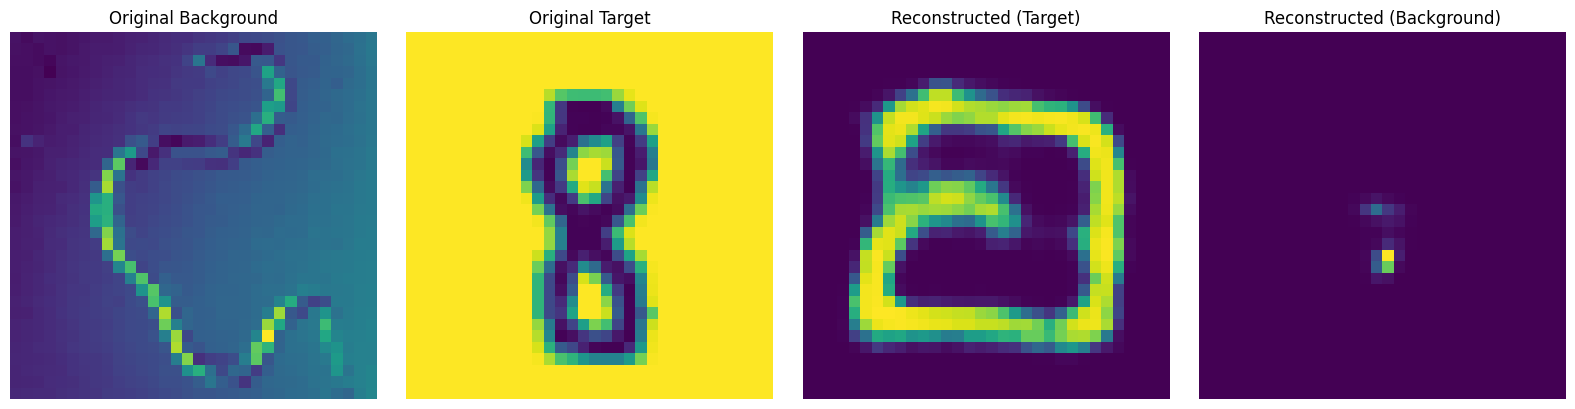

In [57]:
def visualize_outputs(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for tg, bg in dataloader:  # Iterate over batches, we don't need target_image in this version
            # Forward pass to get all the outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_bg, z_log_var_bg, reconstructed_data_target, reconstructed_data_bg = model(tg, bg)

            # Convert tensors to numpy arrays for visualization
            target_images = tg.cpu().numpy().transpose(0, 2, 3, 1)
            recon_images_target = reconstructed_data_target.cpu().numpy().transpose(0, 2, 3, 1)
            recon_images_bg = reconstructed_data_bg.cpu().numpy().transpose(0, 2, 3, 1)

            # Select one image from the batch (index 0)
            target_image = target_images[0]
            recon_image_target = recon_images_target[0]
            recon_image_bg = recon_images_bg[0]
            original_bg = bg[0].cpu().numpy().transpose(1, 2, 0)  # Assuming the bg tensor has shape (batch_size, C, H, W)

            # Plot the original and reconstructed images for target and background
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
            axes[0].imshow(original_bg)
            axes[0].set_title("Original Background")
            axes[0].axis("off")

            axes[1].imshow(target_image)
            axes[1].set_title("Original Target")
            axes[1].axis("off")

            axes[2].imshow(recon_image_target)
            axes[2].set_title("Reconstructed (Target)")
            axes[2].axis("off")

            axes[3].imshow(recon_image_bg)
            axes[3].set_title("Reconstructed (Background)")
            axes[3].axis("off")

            plt.tight_layout()
            plt.show()

            # We have visualized one image, so break the loop
            break

# Assuming you already have a validation dataloader named `val_dataloader`
visualize_outputs(model, overlaid_dataloader, device)


I have figured out why the visuals were off - the background on the mnist images was already at max, therefore the background didnt show. This should fix it. 